# Create results plots

In [41]:
from __future__ import annotations

from copy import deepcopy
from pathlib import Path
from typing import TYPE_CHECKING
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML, display
from scipy.stats import ttest_ind
from tabulate import tabulate
from tilemapbase import Extent

from drone_grid_env.envs.drone_grid_env import DroneGridEnv, ActionSpace
from drone_grid_env.envs.io.kml import read_kml
from drone_grid_env.envs.io.csv import read_csv_by_column_name
from drone_grid_env.utils.plots import create_box_plot, create_line_plot, mean_and_std, sim2matplotlib, orthomosaic2matplotlib

if TYPE_CHECKING:
    from typing import Any

    from matplotlib.figure import Figure
    from numpy.typing import NDArray
    from pygame import Surface

%matplotlib inline

plt.rcParams["text.usetex"] = True

Create some helper functions:

In [18]:
def _print_steps_at_percentage(data: list[NDArray[np.float32]], methods: list[str], percentage: int = 80, value_max: float = 1.0) -> None:
    for i, method_name in enumerate(methods):
        mean_std = mean_and_std(data[i])

        for stp in range(0, 300):
            # Get step at which percantage of weeds is found
            if mean_std[stp, 0] > (percentage / 100) * value_max:
                print(f"{percentage}% weeds found ({mean_std[stp, 0]:.3f} +/- {mean_std[stp, 1]:.3f}) for {method_name} in {stp} steps")
                break
        else:
            print(f"{method_name} does not find more than {percentage}% of the weeds!")


def _save_fig(path: str | Path, fig: Figure, **kwargs: dict[str, Any]) -> None:
    if not isinstance(path, Path):
        path = Path(path)

    if not path.parent.is_dir():
        path.parent.mkdir(parents=True)

    fig.savefig(path, **kwargs)


def _save_subfig(path: str | Path, fig: Figure, ax: plt.Axes, pad: float = 0.1) -> None:
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    bbox = bbox.expanded(1.0 + pad, 1.0 + pad)
    _save_fig(path, fig, bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))


def _flight_path_to_actions(flight_path: NDArray[np.uint16]) -> list[ActionSpace]:
    flight_path = flight_path.astype(np.int16)  # Skip start position
    action_map = {tuple(v): k for k, v in ActionSpace.get_actions_to_flight_map().items()}

    actions = []
    for i in range(1, flight_path.shape[0]):
        diff = tuple(flight_path[i, :] - flight_path[i - 1, :])
        actions.append(action_map[diff])

    return actions


def _display_table(table_html: str) -> None:
    display(
        HTML(
            f"""
        <div style="max-height: 300px; overflow-y: auto; border: 1px solid #ccc;">
            {table_html}
        </div>
        """
        )
    )


def show_details_table(
    data: list[NDArray[np.uint8]], labels: list[str], steps: list[int], sign_with: str = "row-by-row", tablefmt: str = "html"
) -> str:
    rows = []
    for i, name in enumerate(labels):
        row = [name]

        for s in steps:
            mean = np.mean(data[i][:, s - 1])
            std = np.std(data[i][:, s - 1])
            sign = "   "

            if name != sign_with:
                match ttest_ind(data[i][:, s - 1], data[labels.index(sign_with)][:, s], alternative="greater", equal_var=False).pvalue:
                    case p if p <= 0.001:
                        sign = "***"
                    case p if p <= 0.01:
                        sign = "** "
                    case p if p <= 0.05:
                        sign = "*  "

            row.append(f"{mean:.2f}±{std:.2f}{sign}")

        rows.append(row)

    return tabulate(rows, headers=["Method"] + [f"{s} steps" for s in steps], tablefmt=tablefmt)


def _plot_kml_flight_path(kml_file: Path, ax: plt.Axes, episode: int = 0, cwp_threshold: float = 0.80) -> None:
    flight_paths, random_states, metadata = read_kml(kml_file)
    flight_path = flight_paths[f"Episode {episode}"]

    assert flight_path is not None, f"Could not find placemark 'Episode {episode}'!"

    use_random_state = True
    random_state = random_states[list(flight_paths.keys()).index(f"Episode {episode}")]
    if not all(key in random_state for key in ("bit_generator", "state", "has_uint32", "uinteger")):
        use_random_state = False

        # First episode works fine because of the seeding
        if f"Episode {episode}" != list(flight_paths.keys())[0]:
            warn("Cannot get random state from KML data!")

    env = DroneGridEnv(render_mode="rgb_array_headless", config_file=metadata["env_config_file"])

    if use_random_state:
        env.np_random.bit_generator.state = random_state

    env.reset(seed=int(metadata["seed"]) if f"Episode {episode}" == list(flight_paths.keys())[0] else None)

    object_file = kml_file.parent / f"{kml_file.stem}_episode_{episode}_discovered_objects.kml"
    if object_file.is_file():
        found_objects, _, _ = read_kml(object_file, dtype=np.uint16)
        env.drone._found_objects = env.drone._found_objects = [v.reshape(-1, 2) for v in found_objects.values()]

    np.testing.assert_array_equal(env.drone.position, flight_path[0, :], err_msg="Start position is different")

    flight_path_custom = None
    for action in _flight_path_to_actions(flight_path):
        env.step(action)
        if env._get_info()["cwp"] > cwp_threshold and flight_path_custom is None:
            flight_path_custom = deepcopy(env.drone.flight_path)

    if flight_path_custom is None:
        flight_path_custom = deepcopy(env.drone.flight_path)

    def _custom_rendering(surface: Surface) -> None:
        env.rendering.classified_pixels_to_surface(surface)
        env.rendering.flight_path_to_surface(surface, color=(202, 150, 97), width=5)
        env.rendering.drone_to_surface(surface, color=(202, 150, 97))
        env.rendering.fov_to_surface(surface, color=(202, 150, 97), width=5)

        # Plot drone path when XX% of objects are found
        env.rendering.flight_path_to_surface(surface, custom_path=flight_path_custom, color=(106, 86, 199), width=10)
        env.rendering.drone_to_surface(surface, custom_position=flight_path_custom.current_position, color=(106, 86, 199))
        env.rendering.fov_to_surface(surface, custom_position=flight_path_custom.current_position, color=(106, 86, 199), width=10)

    sim2matplotlib(env, ax, plot_drone=False, custom_rendering=_custom_rendering)


def _plot_kml_flight_path_orthomosaic(
    kml_file: Path,
    ax: plt.Axes,
    episode: int = 0,
    expand_lon_lat: tuple[float, float] = (0.0005, 0.0005),
    start_annotation_offset: tuple[int, int] | None = None,
    start_annotation_alignment: str = "left",
    end_annotation_offset: tuple[int, int] | None = None,
    end_annotation_alignment: str = "left",
    custom_extent: Extent | None = None,
) -> None:
    flight_paths, random_states, metadata = read_kml(kml_file)
    flight_path = flight_paths[f"Episode {episode}"]

    assert flight_path is not None, f"Could not find placemark 'Episode {episode}'!"

    use_random_state = True
    random_state = random_states[list(flight_paths.keys()).index(f"Episode {episode}")]
    if not all(key in random_state for key in ("bit_generator", "state", "has_uint32", "uinteger")):
        use_random_state = False

        # First episode works fine because of the seeding
        if f"Episode {episode}" != list(flight_paths.keys())[0]:
            warn("Cannot get random state from KML data!")

    env = DroneGridEnv(render_mode="rgb_array_headless", config_file=metadata["env_config_file"])

    if use_random_state:
        env.np_random.bit_generator.state = random_state

    env.reset(seed=int(metadata["seed"]) if f"Episode {episode}" == list(flight_paths.keys())[0] else None)

    object_file = kml_file.parent / "detected_object_maps" / f"{kml_file.stem}_episode_{episode}.kml"
    if object_file.is_file():
        found_objects, _, _ = read_kml(object_file, dtype=np.uint16)
        env.drone._found_objects = env.drone._found_objects = [v.reshape(-1, 2) for v in found_objects.values()]

    np.testing.assert_array_equal(env.drone.position, flight_path[0, :], err_msg="Start position is different")

    orthomosaic2matplotlib(
        flight_path,
        env,
        ax,
        scalebar_length=50.0,
        linewidth=2.0,
        expand_lon_lat=expand_lon_lat,
        start_annotation_offset=start_annotation_offset,
        start_annotation_alignment=start_annotation_alignment,
        end_annotation_offset=end_annotation_offset,
        end_annotation_alignment=end_annotation_alignment,
        custom_extent=custom_extent,
    )

## Impact object distributions

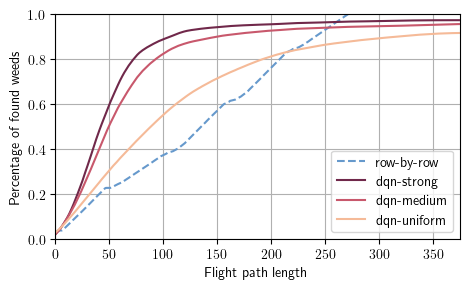

In [19]:
def data_loader(file: Path) -> NDArray[np.floating]:
    return read_csv_by_column_name(
        file, column_name="counted_objects_percentage", value_min=0, value_max=1, expected_n_episodes=1000, n_steps=375
    )


data = [
    data_loader(Path("evaluations/distributions/distribution_random-fields2cover.csv")),
    data_loader(Path("evaluations/distributions/distribution_strong-rl.csv")),
    data_loader(Path("evaluations/distributions/distribution_medium-rl.csv")),
    data_loader(Path("evaluations/distributions/distribution_random-rl.csv")),
]
labels = [
    "row-by-row",
    "dqn-strong",
    "dqn-medium",
    "dqn-uniform",
]
groups = [
    ["dqn-strong", "dqn-medium", "dqn-uniform"],
    ["row-by-row"],
]

custom_colors = ["#6699CC", "#70284a", "#c8586c", "#f5ba98"]

fig, ax = plt.subplots(figsize=(4.8, 3.0))

create_line_plot(
    data,
    ax,
    labels=labels,
    groups=groups,
    unique_color=None,
    conf_interval=False,
    custom_colors=custom_colors,
    xlim=(0, 375),
    ylim=(0, 1),
    xlabel="Flight path length",
    ylabel="Percentage of found weeds",
    legend_loc="lower right",
)

plt.tight_layout()
_save_fig("figures/distributions/distributions_results.pdf", fig)
plt.show()

In [20]:
_print_steps_at_percentage(data, labels, percentage=80)

80% weeds found (0.804 +/- 0.072) for row-by-row in 209 steps
80% weeds found (0.801 +/- 0.189) for dqn-strong in 73 steps
80% weeds found (0.802 +/- 0.134) for dqn-medium in 94 steps
80% weeds found (0.800 +/- 0.067) for dqn-uniform in 193 steps


In [21]:
_display_table(show_details_table(data, labels, [100, 200, 300], sign_with="row-by-row"))

Method,100 steps,200 steps,300 steps
row-by-row,0.37±0.08,0.76±0.07,1.00±0.00
dqn-strong,0.88±0.14***,0.95±0.08***,0.97±0.06
dqn-medium,0.82±0.13***,0.93±0.08***,0.95±0.05
dqn-uniform,0.55±0.06***,0.81±0.07***,0.89±0.05


Latex format:

In [22]:
print(show_details_table(data, labels, [100, 200, 300], sign_with="row-by-row", tablefmt="latex"))

\begin{tabular}{llll}
\hline
 Method      & 100 steps    & 200 steps    & 300 steps   \\
\hline
 row-by-row  & 0.37±0.08    & 0.76±0.07    & 1.00±0.00   \\
 dqn-strong  & 0.88±0.14*** & 0.95±0.08*** & 0.97±0.06   \\
 dqn-medium  & 0.82±0.13*** & 0.93±0.08*** & 0.95±0.05   \\
 dqn-uniform & 0.55±0.06*** & 0.81±0.07*** & 0.89±0.05   \\
\hline
\end{tabular}


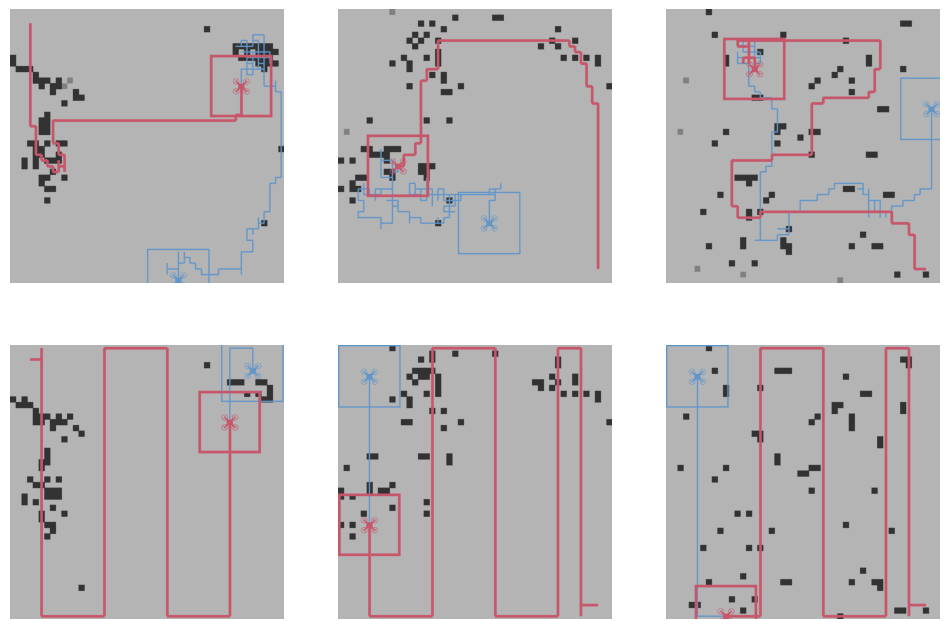

In [23]:
f, axarr = plt.subplots(2, 3, figsize=(12, 8))
_plot_kml_flight_path(Path("evaluations/distributions/distribution_strong-rl.kml"), axarr[0, 0])
_plot_kml_flight_path(Path("evaluations/distributions/distribution_medium-rl.kml"), axarr[0, 1])
_plot_kml_flight_path(Path("evaluations/distributions/distribution_random-rl.kml"), axarr[0, 2])
_plot_kml_flight_path(Path("evaluations/distributions/distribution_strong-fields2cover.kml"), axarr[1, 0])
_plot_kml_flight_path(Path("evaluations/distributions/distribution_medium-fields2cover.kml"), axarr[1, 1])
_plot_kml_flight_path(Path("evaluations/distributions/distribution_random-fields2cover.kml"), axarr[1, 2])

_save_subfig("figures/distributions/distribution_strong_flight_path_rl.pdf", f, axarr[0, 0])
_save_subfig("figures/distributions/distribution_medium_flight_path_rl.pdf", f, axarr[0, 1])
_save_subfig("figures/distributions/distribution_random_flight_path_rl.pdf", f, axarr[0, 2])
_save_subfig("figures/distributions/distribution_strong_flight_path_fields2cover.pdf", f, axarr[1, 0])
_save_subfig("figures/distributions/distribution_medium_flight_path_fields2cover.pdf", f, axarr[1, 1])
_save_subfig("figures/distributions/distribution_random_flight_path_fields2cover.pdf", f, axarr[1, 2])

plt.show()

## Influence of detection errors

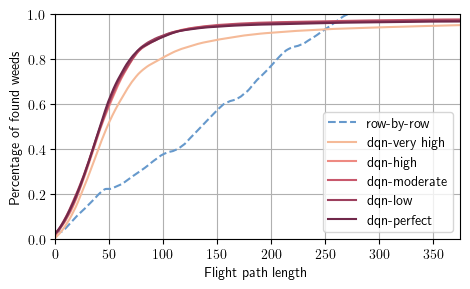

In [27]:
def data_loader(file: Path) -> NDArray[np.floating]:
    return read_csv_by_column_name(
        file, column_name="counted_objects_percentage", value_min=0, value_max=1, expected_n_episodes=1000, n_steps=375
    )


data = [
    data_loader(Path("evaluations/detection_errors/detection_uncertainty-fields2cover.csv")),
    data_loader(Path("evaluations/detection_errors/detection_uncertainty_level_0-rl.csv")),
    data_loader(Path("evaluations/detection_errors/detection_uncertainty_level_1-rl.csv")),
    data_loader(Path("evaluations/detection_errors/detection_uncertainty_level_2-rl.csv")),
    data_loader(Path("evaluations/detection_errors/detection_uncertainty_level_3-rl.csv")),
    data_loader(Path("evaluations/detection_errors/detection_uncertainty_level_4-rl.csv")),
]
labels = [
    "row-by-row",
    "dqn-very high",
    "dqn-high",
    "dqn-moderate",
    "dqn-low",
    "dqn-perfect",
]
groups = [
    ["dqn-very high", "dqn-high", "dqn-moderate", "dqn-low", "dqn-perfect"],
    ["row-by-row"],
]

custom_colors = ["#6699CC", "#f5ba98", "#ee8a82", "#c8586c", "#9c3f5d", "#70284a"]

fig, ax = plt.subplots(figsize=(4.8, 3.0))

create_line_plot(
    data,
    ax,
    labels=labels,
    groups=groups,
    unique_color=None,
    conf_interval=False,
    custom_colors=custom_colors,
    xlim=(0, 375),
    ylim=(0, 1),
    xlabel="Flight path length",
    ylabel="Percentage of found weeds",
    legend_loc="lower right",
)

plt.tight_layout()
_save_fig("figures/detection_errors/detection_levels_results.pdf", fig)
plt.show()

In [28]:
_print_steps_at_percentage(data, labels, percentage=80)

80% weeds found (0.802 +/- 0.230) for row-by-row in 206 steps
80% weeds found (0.801 +/- 0.169) for dqn-very high in 98 steps
80% weeds found (0.801 +/- 0.178) for dqn-high in 72 steps
80% weeds found (0.803 +/- 0.175) for dqn-moderate in 72 steps
80% weeds found (0.806 +/- 0.184) for dqn-low in 72 steps
80% weeds found (0.802 +/- 0.184) for dqn-perfect in 70 steps


In [30]:
show_details_table(data, labels, [100, 200, 300], sign_with="row-by-row")

Method,100 steps,200 steps,300 steps
row-by-row,0.37±0.30,0.76±0.25,1.00±0.00
dqn-very high,0.80±0.17***,0.92±0.08***,0.94±0.06
dqn-high,0.90±0.11***,0.96±0.05***,0.97±0.04
dqn-moderate,0.90±0.12***,0.96±0.05***,0.97±0.04
dqn-low,0.90±0.13***,0.96±0.05***,0.97±0.04
dqn-perfect,0.90±0.13***,0.95±0.07***,0.96±0.06


Show latex:

In [31]:
print(show_details_table(data, labels, [100, 200, 300], sign_with="row-by-row", tablefmt="latex"))

\begin{tabular}{llll}
\hline
 Method        & 100 steps    & 200 steps    & 300 steps   \\
\hline
 row-by-row    & 0.37±0.30    & 0.76±0.25    & 1.00±0.00   \\
 dqn-very high & 0.80±0.17*** & 0.92±0.08*** & 0.94±0.06   \\
 dqn-high      & 0.90±0.11*** & 0.96±0.05*** & 0.97±0.04   \\
 dqn-moderate  & 0.90±0.12*** & 0.96±0.05*** & 0.97±0.04   \\
 dqn-low       & 0.90±0.13*** & 0.96±0.05*** & 0.97±0.04   \\
 dqn-perfect   & 0.90±0.13*** & 0.95±0.07*** & 0.96±0.06   \\
\hline
\end{tabular}


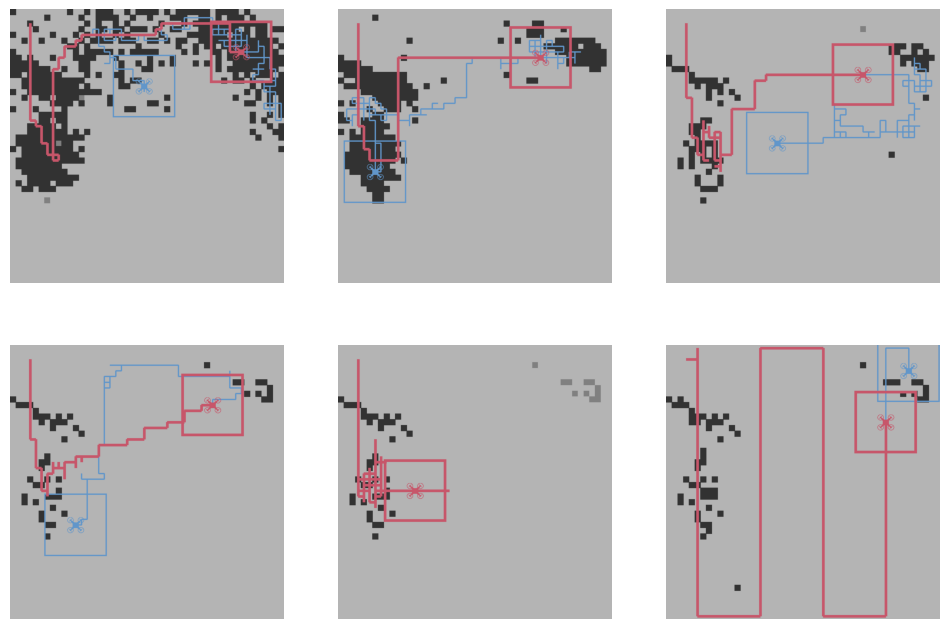

In [32]:
f, axarr = plt.subplots(2, 3, figsize=(12, 8))
_plot_kml_flight_path(Path("evaluations/detection_errors/detection_uncertainty_level_0-rl.kml"), axarr[0, 0])
_plot_kml_flight_path(Path("evaluations/detection_errors/detection_uncertainty_level_1-rl.kml"), axarr[0, 1])
_plot_kml_flight_path(Path("evaluations/detection_errors/detection_uncertainty_level_2-rl.kml"), axarr[0, 2])
_plot_kml_flight_path(Path("evaluations/detection_errors/detection_uncertainty_level_3-rl.kml"), axarr[1, 0])
_plot_kml_flight_path(Path("evaluations/detection_errors/detection_uncertainty_level_4-rl.kml"), axarr[1, 1])
_plot_kml_flight_path(Path("evaluations/detection_errors/detection_uncertainty-fields2cover.kml"), axarr[1, 2])

_save_subfig("figures/detection_errors/detection_level_0_flight_path_rl.pdf", f, axarr[0, 0])
_save_subfig("figures/detection_errors/detection_level_1_flight_path_rl.pdf", f, axarr[0, 1])
_save_subfig("figures/detection_errors/detection_level_2_flight_path_rl.pdf", f, axarr[0, 2])
_save_subfig("figures/detection_errors/detection_level_3_flight_path_rl.pdf", f, axarr[1, 0])
_save_subfig("figures/detection_errors/detection_level_4_flight_path_rl.pdf", f, axarr[1, 1])
_save_subfig("figures/detection_errors/detection_flight_path_fields2cover.pdf", f, axarr[1, 2])

plt.show()

## Influence prior knowledge quality

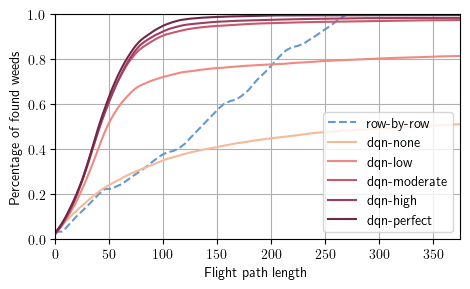

In [33]:
def data_loader(file: Path) -> NDArray[np.floating]:
    return read_csv_by_column_name(
        file, column_name="counted_objects_percentage", value_min=0, value_max=1, expected_n_episodes=1000, n_steps=375
    )


data = [
    data_loader(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty-fields2cover.csv")),
    data_loader(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_0-rl.csv")),
    data_loader(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_1-rl.csv")),
    data_loader(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_2-rl.csv")),
    data_loader(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_3-rl.csv")),
    data_loader(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_4-rl.csv")),
]
labels = [
    "row-by-row",
    "dqn-none",
    "dqn-low",
    "dqn-moderate",
    "dqn-high",
    "dqn-perfect",
]
groups = [
    ["dqn-none", "dqn-low", "dqn-moderate", "dqn-high", "dqn-perfect"],
    ["row-by-row"],
]

custom_colors = ["#6699CC", "#f5ba98", "#ee8a82", "#c8586c", "#9c3f5d", "#70284a"]

fig, ax = plt.subplots(figsize=(4.8, 3.0))

create_line_plot(
    data,
    ax,
    labels=labels,
    groups=groups,
    unique_color=None,
    conf_interval=False,
    custom_colors=custom_colors,
    xlim=(0, 375),
    ylim=(0, 1),
    xlabel="Flight path length",
    ylabel="Percentage of found weeds",
    legend_loc="lower right",
)

plt.tight_layout()
_save_fig("figures/prior_knowledge_quality/prior_knowledge_levels_results.pdf", fig)
plt.show()

In [34]:
_print_steps_at_percentage(data, labels, percentage=80)

80% weeds found (0.802 +/- 0.230) for row-by-row in 206 steps
dqn-none does not find more than 80% of the weeds!
80% weeds found (0.800 +/- 0.200) for dqn-low in 292 steps
80% weeds found (0.804 +/- 0.186) for dqn-moderate in 71 steps
80% weeds found (0.801 +/- 0.185) for dqn-high in 69 steps
80% weeds found (0.806 +/- 0.189) for dqn-perfect in 67 steps


In [36]:
show_details_table(data, labels, [100, 200, 300], sign_with="row-by-row")

Method,100 steps,200 steps,300 steps
row-by-row,0.37±0.30,0.76±0.25,1.00±0.00
dqn-none,0.35±0.32,0.45±0.33,0.49±0.33
dqn-low,0.72±0.24***,0.78±0.22,0.80±0.20
dqn-moderate,0.90±0.12***,0.96±0.05***,0.97±0.05
dqn-high,0.92±0.10***,0.97±0.03***,0.98±0.03
dqn-perfect,0.94±0.08***,0.99±0.02***,0.99±0.01


Show latex:

In [37]:
print(show_details_table(data, labels, [100, 200, 300], sign_with="row-by-row", tablefmt="latex"))

\begin{tabular}{llll}
\hline
 Method       & 100 steps    & 200 steps    & 300 steps   \\
\hline
 row-by-row   & 0.37±0.30    & 0.76±0.25    & 1.00±0.00   \\
 dqn-none     & 0.35±0.32    & 0.45±0.33    & 0.49±0.33   \\
 dqn-low      & 0.72±0.24*** & 0.78±0.22    & 0.80±0.20   \\
 dqn-moderate & 0.90±0.12*** & 0.96±0.05*** & 0.97±0.05   \\
 dqn-high     & 0.92±0.10*** & 0.97±0.03*** & 0.98±0.03   \\
 dqn-perfect  & 0.94±0.08*** & 0.99±0.02*** & 0.99±0.01   \\
\hline
\end{tabular}


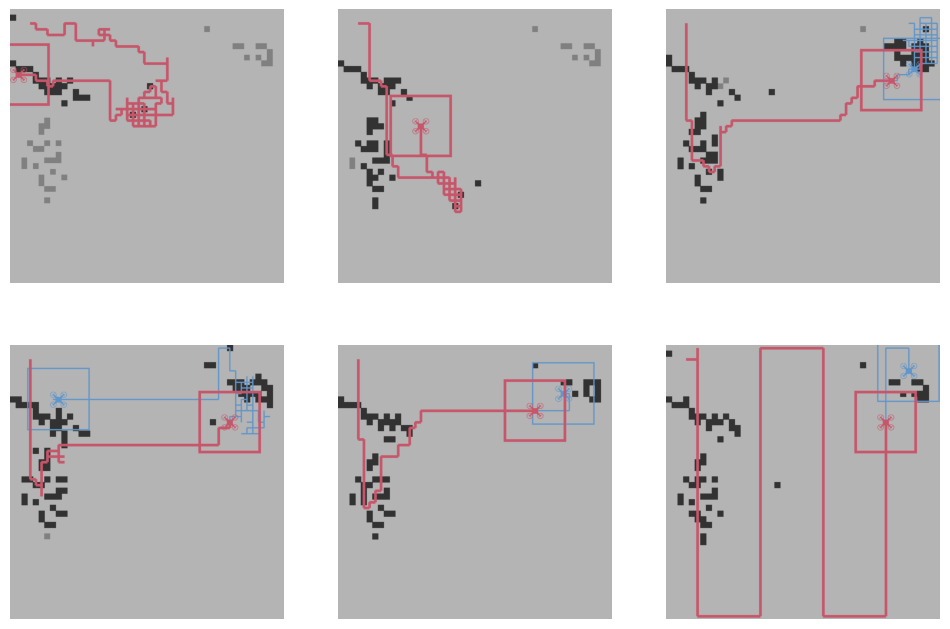

In [39]:
f, axarr = plt.subplots(2, 3, figsize=(12, 8))
_plot_kml_flight_path(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_0-rl.kml"), axarr[0, 0])
_plot_kml_flight_path(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_1-rl.kml"), axarr[0, 1])
_plot_kml_flight_path(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_2-rl.kml"), axarr[0, 2])
_plot_kml_flight_path(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_3-rl.kml"), axarr[1, 0])
_plot_kml_flight_path(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty_level_4-rl.kml"), axarr[1, 1])
_plot_kml_flight_path(Path("evaluations/prior_knowledge_quality/prior_knowledge_uncertainty-fields2cover.kml"), axarr[1, 2])

_save_subfig("figures/prior_knowledge_quality/prior_knowledge_level_0_flight_path_rl.pdf", f, axarr[0, 0])
_save_subfig("figures/prior_knowledge_quality/prior_knowledge_level_1_flight_path_rl.pdf", f, axarr[0, 1])
_save_subfig("figures/prior_knowledge_quality/prior_knowledge_level_2_flight_path_rl.pdf", f, axarr[0, 2])
_save_subfig("figures/prior_knowledge_quality/prior_knowledge_level_3_flight_path_rl.pdf", f, axarr[1, 0])
_save_subfig("figures/prior_knowledge_quality/prior_knowledge_level_4_flight_path_rl.pdf", f, axarr[1, 1])
_save_subfig("figures/prior_knowledge_quality/prior_knowledge_flight_path_fields2cover.pdf", f, axarr[1, 2])

plt.show()

## Effect of different stopping criteria

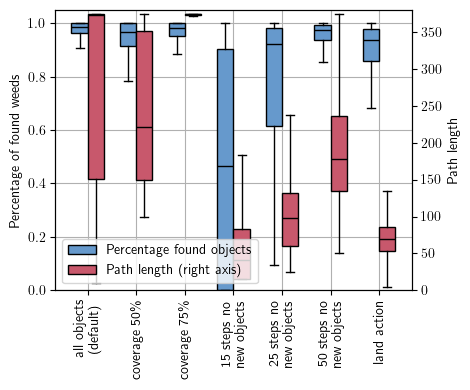

In [42]:
def data_loader_objects(file: Path) -> NDArray[np.floating]:
    return read_csv_by_column_name(
        file, column_name="counted_objects_percentage", value_min=0, value_max=1, expected_n_episodes=1000, n_steps=375
    )


def data_loader_path_length(file: Path) -> NDArray[np.floating]:
    return read_csv_by_column_name(file, column_name="path_length", value_min=0, value_max=375, expected_n_episodes=1000, n_steps=375)


data = [
    data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_all_objects-rl.csv"))[:, -1],
    data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_coverage_50-rl.csv"))[:, -1],
    data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_coverage_75-rl.csv"))[:, -1],
    data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_new_objects_15-rl.csv"))[:, -1],
    data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_new_objects_25-rl.csv"))[:, -1],
    data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_new_objects_50-rl.csv"))[:, -1],
    data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_land-rl.csv"))[:, -1],
    data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_all_objects-rl.csv"))[:, -1],
    data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_coverage_50-rl.csv"))[:, -1],
    data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_coverage_75-rl.csv"))[:, -1],
    data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_new_objects_15-rl.csv"))[:, -1],
    data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_new_objects_25-rl.csv"))[:, -1],
    data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_new_objects_50-rl.csv"))[:, -1],
    data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_land-rl.csv"))[:, -1],
]

labels = [
    "number_objects_stopping_criteria_1",
    "number_objects_stopping_criteria_2",
    "number_objects_stopping_criteria_3",
    "number_objects_stopping_criteria_4",
    "number_objects_stopping_criteria_5",
    "number_objects_stopping_criteria_6",
    "number_objects_stopping_criteria_7",
    "path_length_stopping_criteria_1",
    "path_length_stopping_criteria_2",
    "path_length_stopping_criteria_3",
    "path_length_stopping_criteria_4",
    "path_length_stopping_criteria_5",
    "path_length_stopping_criteria_6",
    "path_length_stopping_criteria_7",
]
groups = [
    [
        "number_objects_stopping_criteria_1",
        "number_objects_stopping_criteria_2",
        "number_objects_stopping_criteria_3",
        "number_objects_stopping_criteria_4",
        "number_objects_stopping_criteria_5",
        "number_objects_stopping_criteria_6",
        "number_objects_stopping_criteria_7",
    ],
    [
        "path_length_stopping_criteria_1",
        "path_length_stopping_criteria_2",
        "path_length_stopping_criteria_3",
        "path_length_stopping_criteria_4",
        "path_length_stopping_criteria_5",
        "path_length_stopping_criteria_6",
        "path_length_stopping_criteria_7",
    ],
]
group_labels = ["Percentage found objects", "Path length (right axis)"]
category_labels = [
    "all objects\n(default)",
    "coverage 50\%",
    "coverage 75\%",
    "15 steps no\nnew objects",
    "25 steps no\nnew objects",
    "50 steps no\nnew objects",
    "land action",
]

custom_colors = ["#6699CC", "#c8586c"]

fig, ax = plt.subplots(figsize=(4.8, 4.0))

create_box_plot(
    data,
    ax,
    labels=labels,
    groups=groups,
    group_labels=group_labels,
    category_labels=category_labels,
    custom_colors=custom_colors,
    showoutliers=False,
    ylim=(0, 1.05),
    ylabel="Percentage of found weeds",
    legend_loc="lower left",
    secondary_axis_groups=["Path length (right axis)"],
    secondary_axis_label="Path length",
    secondary_axis_ylim=(0, 380),
)

fig.tight_layout()
_save_fig("figures/stopping_criteria/stopping_criteria_found_objects.pdf", fig)
plt.show()

In [44]:
def get_sign_sign(data: NDArray[np.floating], reference: NDArray[np.floating], alternative: str) -> str:
    match ttest_ind(data, reference, alternative=alternative, equal_var=False).pvalue:
        case p if p <= 0.001:
            return "***"
        case p if p <= 0.01:
            return "** "
        case p if p <= 0.05:
            return "*  "

    return "   "


f2c_objects = data_loader_objects(Path("evaluations/stopping_criteria/stopping_criteria_land-fields2cover.csv"))[:, -1]
f2c_pl = data_loader_path_length(Path("evaluations/stopping_criteria/stopping_criteria_land-fields2cover.csv"))[:, -1]

method = ["row_by_row"] + [c.replace("\n", " ").replace("\\", "") for c in category_labels]
found_objects = [f2c_objects] + [data[i] for i, lbl in enumerate(labels) if "number_objects" in lbl]
path_length = [f2c_pl] + [data[i] for i, lbl in enumerate(labels) if "path_length" in lbl]

sign_with = "row_by_row"

table_data = []
for m, fo, pl in zip(method, found_objects, path_length):
    sign_objects = "   "
    sign_pl = "   "

    if m != sign_with:
        sign_objects = get_sign_sign(fo, found_objects[method.index(sign_with)], "two-sided")
        sign_pl = get_sign_sign(pl, path_length[method.index(sign_with)], "less")

    table_data.append([m, f"{np.mean(fo):.2f}±{np.std(fo):.2f}{sign_objects}", f"{np.mean(pl):.0f}±{np.std(pl):.0f}{sign_pl}"])

_display_table(tabulate(table_data, headers=["Method", "Percentage found objects", "Path length"], tablefmt="html"))

Method,Percentage found objects,Path length
row_by_row,1.00±0.00,276±0
all objects (default),0.98±0.03***,281±130
coverage 50%,0.94±0.08***,239±97***
coverage 75%,0.97±0.06***,371±14
15 steps no new objects,0.45±0.42***,52±40***
25 steps no new objects,0.72±0.38***,98±52***
50 steps no new objects,0.94±0.14***,193±79***
land action,0.88±0.16***,71±31***


In [45]:
print(tabulate(table_data, headers=["Method", "Percentage found objects", "Path length"], tablefmt="latex"))

\begin{tabular}{lll}
\hline
 Method                  & Percentage found objects   & Path length   \\
\hline
 row\_by\_row              & 1.00±0.00                  & 276±0         \\
 all objects (default)   & 0.98±0.03***               & 281±130       \\
 coverage 50\%            & 0.94±0.08***               & 239±97***     \\
 coverage 75\%            & 0.97±0.06***               & 371±14        \\
 15 steps no new objects & 0.45±0.42***               & 52±40***      \\
 25 steps no new objects & 0.72±0.38***               & 98±52***      \\
 50 steps no new objects & 0.94±0.14***               & 193±79***     \\
 land action             & 0.88±0.16***               & 71±31***      \\
\hline
\end{tabular}


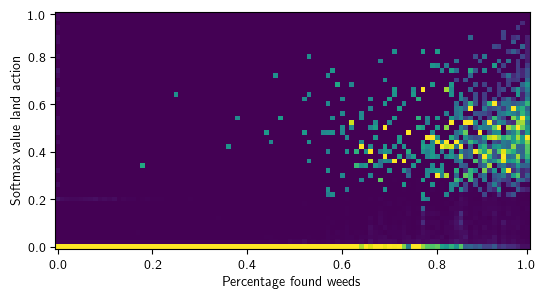

In [46]:
land_evaluation = Path("evaluations/stopping_criteria/stopping_criteria_land-rl.csv")

land_action_values_0 = read_csv_by_column_name(
    land_evaluation, column_name="action_value_0", expected_n_episodes=1000, n_steps=375
).flatten()
land_action_values_1 = read_csv_by_column_name(
    land_evaluation, column_name="action_value_1", expected_n_episodes=1000, n_steps=375
).flatten()
land_action_values_2 = read_csv_by_column_name(
    land_evaluation, column_name="action_value_2", expected_n_episodes=1000, n_steps=375
).flatten()
land_action_values_3 = read_csv_by_column_name(
    land_evaluation, column_name="action_value_3", expected_n_episodes=1000, n_steps=375
).flatten()
land_action_values_4 = read_csv_by_column_name(
    land_evaluation, column_name="action_value_4", expected_n_episodes=1000, n_steps=375
).flatten()

action_values = np.vstack((land_action_values_0, land_action_values_1, land_action_values_2, land_action_values_3, land_action_values_4)).T
action_values_softmax = np.exp(action_values - np.max(action_values, axis=1, keepdims=True)) / np.sum(
    np.exp(action_values - np.max(action_values, axis=1, keepdims=True)), axis=1, keepdims=True
)

x = read_csv_by_column_name(
    land_evaluation, column_name="counted_objects_percentage", value_min=0, value_max=1, expected_n_episodes=1000, n_steps=375
).flatten()
y = action_values_softmax[:, -1].flatten()

histogram, x_edges, y_edges = np.histogram2d(x, y, bins=[100, 50])
histogram = histogram.transpose()
histogram_norm = (histogram - histogram.min(axis=0)) / (histogram.max(axis=0) - histogram.min(axis=0) + 1e-7)

fig, ax = plt.subplots(figsize=(5.6, 3.0))
img = ax.imshow(histogram_norm, origin="lower", cmap="viridis")
ax.set_xlabel("Percentage found weeds")
ax.set_ylabel("Softmax value land action")
ax.set_xticks([0, 20, 40, 60, 80, 99], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks([0, 10, 20, 30, 40, 49], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout()
_save_fig("figures/stopping_criteria/land_action_histogram_normalized.pdf", fig)
plt.show()

In [47]:
print(f"Percentage stopped before 5 steps {np.sum(data[-1] <= 1) / len(data[-1])}")

Percentage stopped before 5 steps 0.017


## Real-world showcase

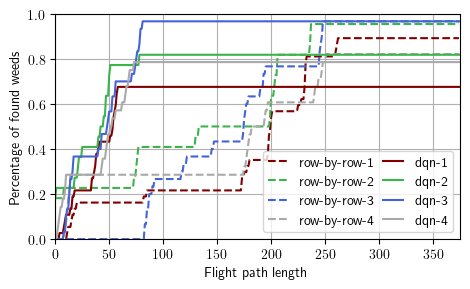

In [48]:
def data_loader(file: Path) -> NDArray[np.floating]:
    return read_csv_by_column_name(
        file, column_name="counted_objects_percentage", value_min=0, value_max=1, expected_n_episodes=1, n_steps=375
    )


data = [
    data_loader(Path("evaluations/showcase/clustered_1-fields2cover.csv")),
    data_loader(Path("evaluations/showcase/clustered_2-fields2cover.csv")),
    data_loader(Path("evaluations/showcase/clustered_3-fields2cover.csv")),
    data_loader(Path("evaluations/showcase/clustered_4-fields2cover.csv")),
    data_loader(Path("evaluations/showcase/clustered_1-rl.csv")),
    data_loader(Path("evaluations/showcase/clustered_2-rl.csv")),
    data_loader(Path("evaluations/showcase/clustered_3-rl.csv")),
    data_loader(Path("evaluations/showcase/clustered_4-rl.csv")),
]
labels = [
    "row-by-row-1",
    "row-by-row-2",
    "row-by-row-3",
    "row-by-row-4",
    "dqn-1",
    "dqn-2",
    "dqn-3",
    "dqn-4",
]
groups = [
    ["dqn-1", "dqn-2", "dqn-3", "dqn-4"],
    ["row-by-row-1", "row-by-row-2", "row-by-row-3", "row-by-row-4"],
]

# custom_colors = ["#6699CC", "#f5ba98", "#ee8a82", "#c8586c", "#9c3f5d", "#70284a"]

fig, ax = plt.subplots(figsize=(4.8, 3.0))

create_line_plot(
    data,
    ax,
    labels=labels,
    groups=groups,
    unique_color=None,
    conf_interval=False,
    # custom_colors=custom_colors,
    xlim=(0, 375),
    ylim=(0, 1),
    xlabel="Flight path length",
    ylabel="Percentage of found weeds",
    legend_loc="lower right",
    legend_kwargs={"ncol": 2, "columnspacing": 0.5, "handlelength": 1.5},
)

plt.tight_layout()
_save_fig("figures/showcase/datasets_results.pdf", fig)
plt.show()

In [49]:
def get_path_length(file: Path) -> int:
    return read_csv_by_column_name(file, column_name="path_length", value_min=0, value_max=375, expected_n_episodes=1, n_steps=375)[-1, -1]


path_length = [
    get_path_length(Path("evaluations/showcase/clustered_1-fields2cover.csv")),
    get_path_length(Path("evaluations/showcase/clustered_2-fields2cover.csv")),
    get_path_length(Path("evaluations/showcase/clustered_3-fields2cover.csv")),
    get_path_length(Path("evaluations/showcase/clustered_4-fields2cover.csv")),
    get_path_length(Path("evaluations/showcase/clustered_1-rl.csv")),
    get_path_length(Path("evaluations/showcase/clustered_2-rl.csv")),
    get_path_length(Path("evaluations/showcase/clustered_3-rl.csv")),
    get_path_length(Path("evaluations/showcase/clustered_4-rl.csv")),
]

for i, lbl in enumerate(labels):
    print(f"{data[i][-1, -1] * 100:.2f}% of objects found for '{lbl}' in {path_length[i]:.0f} flight steps")

obj_found_rl = np.array([data[i][-1, -1] for i, lbl in enumerate(labels) if "dqn" in lbl])
obj_found_f2c = np.array([data[i][-1, -1] for i, lbl in enumerate(labels) if "row-by-row" in lbl])
pl_rl = np.array([path_length[i] for i, lbl in enumerate(labels) if "dqn" in lbl])
pl_f2c = np.array([path_length[i] for i, lbl in enumerate(labels) if "row-by-row" in lbl])

print(f"DQN: {obj_found_rl.mean() * 100:.2f}±{obj_found_rl.std() * 100:.2f}% in {pl_rl.mean():.0f}±{pl_rl.std():.0f} steps")
print(f"Row-by-row: {obj_found_f2c.mean() * 100:.2f}±{obj_found_f2c.std() * 100:.2f}% in {pl_f2c.mean():.0f}±{pl_f2c.std():.0f} steps")


89.19% of objects found for 'row-by-row-1' in 276 flight steps
95.45% of objects found for 'row-by-row-2' in 276 flight steps
96.67% of objects found for 'row-by-row-3' in 276 flight steps
82.14% of objects found for 'row-by-row-4' in 276 flight steps
67.57% of objects found for 'dqn-1' in 62 flight steps
81.82% of objects found for 'dqn-2' in 78 flight steps
96.67% of objects found for 'dqn-3' in 94 flight steps
78.57% of objects found for 'dqn-4' in 144 flight steps
DQN: 81.16±10.40% in 94±31 steps
Row-by-row: 90.86±5.78% in 276±0 steps


Real-world flight paths:

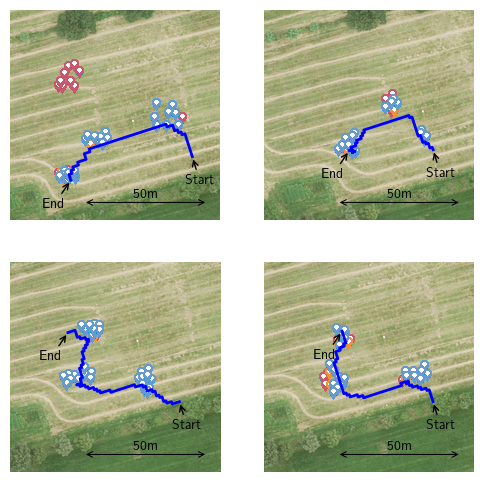

In [54]:
f, axarr = plt.subplots(2, 2, figsize=(6, 6))
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_1-rl.kml"),
    axarr[0, 0],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157441697063252, 0.33035511307909327, xsize=0.0000034),
)
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_2-rl.kml"),
    axarr[0, 1],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157435886966474, 0.3303552685519455, xsize=0.0000034),
)
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_3-rl.kml"),
    axarr[1, 0],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157441068935587, 0.33035563322291134, xsize=0.0000034),
)
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_4-rl.kml"),
    axarr[1, 1],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157442172127763, 0.3303556945782363, xsize=0.0000034),
)

_save_subfig("figures/showcase/clustered_1_rl_flight_path.pdf", f, axarr[0, 0])
_save_subfig("figures/showcase/clustered_2_rl_flight_path.pdf", f, axarr[0, 1])
_save_subfig("figures/showcase/clustered_3_rl_flight_path.pdf", f, axarr[1, 0])
_save_subfig("figures/showcase/clustered_4_rl_flight_path.pdf", f, axarr[1, 1])

plt.show()

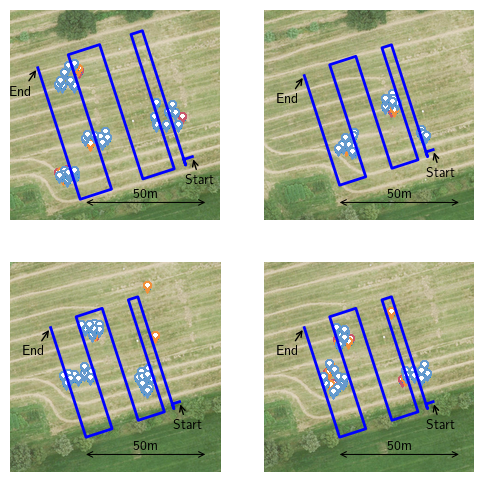

In [55]:
f, axarr = plt.subplots(2, 2, figsize=(6, 6))
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_1-fields2cover.kml"),
    axarr[0, 0],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157441697063252, 0.33035511307909327, xsize=0.0000034),
)
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_2-fields2cover.kml"),
    axarr[0, 1],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157435886966474, 0.3303552685519455, xsize=0.0000034),
)
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_3-fields2cover.kml"),
    axarr[1, 0],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157441068935587, 0.33035563322291134, xsize=0.0000034),
)
_plot_kml_flight_path_orthomosaic(
    Path("evaluations/showcase/clustered_4-fields2cover.kml"),
    axarr[1, 1],
    start_annotation_offset=(-5, -20),
    end_annotation_offset=(-20, -20),
    custom_extent=Extent.from_centre(0.5157442172127763, 0.3303556945782363, xsize=0.0000034),
)
_save_subfig("figures/showcase/clustered_1_fields2cover_flight_path.pdf", f, axarr[0, 0])
_save_subfig("figures/showcase/clustered_2_fields2cover_flight_path.pdf", f, axarr[0, 1])
_save_subfig("figures/showcase/clustered_3_fields2cover_flight_path.pdf", f, axarr[1, 0])
_save_subfig("figures/showcase/clustered_4_fields2cover_flight_path.pdf", f, axarr[1, 1])

plt.show()